In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import odeint

%matplotlib inline

In [2]:
"""Constants"""
eps0 = 8.854e-12 #[F/m]
e = 1.60217662e-19 #elementary charge [C]
h = 6.62607004e-34 #Planck's constant [Js]
m_e = 9.10938356e-31 #electron mass [kg]

In [3]:
"""Material dependant constants:"""
'''Fluid'''
fluid_density_list = [0.164, 1.205, 1.98] #He, air, CO2
eta_list = [1.96e-5, 1.81e-5, 1.47e-5] #shear viscosity = kinematic viscosity * denisty of fluid
eps_list = [eps0, eps0, 1.44*eps0] #permitivity
k_list = [1/(4*math.pi*eps_list[0]), 1/(4*math.pi*eps_list[1]), 1/(4*math.pi*eps_list[2])] 
lp_list = [17.5e-3, 6.7e-3, 4e-3]
pressure = 101.325e3
temp = 298.15
A1_list = [1.277, 1.207, 1.15]

'''QDs'''
#(InAs/GaAs QDs)
Rt = (10*h)/(e**2) #tunneling resistance (made up value)
m_eeff = 0.067 * m_e #electron effective mass [kg]
m_heff = 0.34 * m_e #hole effective mass [kg]
E_g = 0.36 * 1.60217662e-19 #band gap of QD (InAs bulk) [J]


'''Inner section'''
cap_d = 0.394    #capacitance density in [F/m^2] of inner segment capacitors
rho = 3e3 # desity of inner disc material (approxmiate) [kg/m^3]
R_c = 1 #capacitor circuit resistance

In [4]:
"""Initial parameter functions"""
def seperation_angle(n):
    return ( (2*math.pi)/n )

def setup_radius(sep, diam, PHI):
    return ( (sep + diam)/(2 * math.sin(PHI/2)) )

def cog_length( Rp, PHI):
    r = ( Rp*math.sin(PHI) )/(4*math.sin(PHI/2))
    return r

def width( Rp, PHI):
    w = ( Rp*math.sin(PHI) )/2
    return w

def inertia2 (rho, thc, r, w, Rp):
    """Calculates inertia of inner rotating section"""
    m_cog = rho*thc*w*r
    m_disc = math.pi * ((Rp-r)**2)*thc*rho
    I2 = m_cog*((r**2) + (w**2)) + 12*m_cog*((Rp-(r/2))**2) + m_disc*((Rp-r)**2)
    return I2

In [5]:
"""Motor setup functions"""

def permanent_charge_magnitude( r, width, cap_d, cap_vol):
    """Calculates magnitude of total charge stored in inner segment"""
    segment_area = (r/2) * width
    capacitance = cap_d * segment_area #capacitance of one segment
    stored_charge = capacitance * cap_vol #stored charge in one segment
    return stored_charge

def permanent_charges( Rp, p , cap_d, cap_vol, width, r):
    """Initializes permanent charge elements"""
    PCs = {}
    for i in range(p):
        theta = (2*math.pi/p)*i
        xp = Rp*math.cos(theta)
        yp = Rp*math.sin(theta)
        if i%2 == 0:
            p_ch = permanent_charge_magnitude( r, width, cap_d, cap_vol)
        else:
            p_ch = -permanent_charge_magnitude( r, width, cap_d, cap_vol)
        PCs.update({i:[xp,yp,theta, p_ch]}) #dictionary containing all info of permanent charges
    return PCs

def quantum_dots( n, e, noc):
    """Initializes quantum dot elements"""
    QDs = {}
    for i in range(n):
        fi = (2*math.pi/n)*i
        x = R*math.cos(fi)
        y = R*math.sin(fi)
        if i in range(1, n, 4): #will result in +ve torque ==> turning anti-clockwise
            q_ch = noc*e
        elif i in range(3, n, 4):
            q_ch = -noc*e
        else:
            q_ch = 0
        QDs.update({i:[x,y,fi,q_ch]}) #dictionary containing all info on QDs
    return QDs

In [6]:
"""Friction coefficient calculator functions"""

def C(eta0, sigma, Cc):
    coef = (6*math.pi*eta0*sigma)/Cc
    return coef

def Cunningham_correction(A1, lp, pressure, temp, R):
    l = (lp * temp)/(273.15 * pressure) #mean free path
    Kn = l/R #Knudsen number
    Cc = 1 + (A1 * Kn) #only valid for Kn<0.4?
    return Cc    

def  f_t(C, eta0, N, s):
    f = 1/( (1/(N*C)) + ( s/(6*math.pi*(N**2)*eta0) ) )
    return f

def average_inverse_sum( position, N):
    i = 0
    j = 0
    s = 0
    for i in range(N):
        for j in range(N):
            if ( i == j ):
                s += 0
            else:
                r = r_ij(i, j, position)
                s += 1/r
    return s

def positions(Nx, Ny, sigma):
    position = {}
    i = 0
    j = 0
    m = 0
    for j in range(Ny):
        for i in range(Nx):
            x = sigma + 2 * i  * sigma
            y = sigma + 2 * j * sigma
            position.update({m:[x,y]})
            m += 1
    return position

def r_ij(i, j, position):
    distance = math.sqrt( ((position[i][0]-position[j][0])**2) + ((position[i][1]-position[j][1])**2) )
    return distance

def friction_function(eta, thc, width, Cc):
    m = 10
    sigma = 5e-9
    sigmax = 5e-9
    s_array = []
    sigma_array = []
    N_array = []
    f_array = []
    for i in np.arange( 0, m):
        sigma_array.append(sigmax)
        Nx = int(width/(2*sigmax))
        Ny = int(thc/(2*sigmax))
        N = Nx * Ny
        N_array.append(N)
        const = C(eta, sigmax, Cc)
        coord = positions(Nx, Ny, sigmax)
        s = average_inverse_sum(coord, N)
        s_array.append(s)
        friction = f_t(const, eta, N, s)
        f_array.append(friction)
        sigmax = sigma/(i+2)
    return (f_array[m-1])

In [7]:
"""Active motor functions"""

def tangential_component(k , n, e, R, Rp, gamma, noc, width, r):
    """Calculates the tangential coulomb force on one inner charge"""
    F_c = 0; #coulomb force
    F_t = 0 #tangential component of coulumb force
    QDs = quantum_dots(n, e, noc) #calls function to initialize QDs
    for i in range(n):
        Q = QDs[i] #dictionary section on ith QD
        ri = math.sqrt(2*R*(R-r0)*(1-math.cos(QDs[i][2]-gamma))+r0**2) #distance between QD and permanent charge edge
        ric = math.sqrt(  ( (Rp-(r/4) )**2) + (R**2) - 2*(Rp-(r/4))*R*math.cos(QDs[i][2]-gamma) ) #distance between QD and permanent charge center
        d = 2*R*math.sin((QDs[i][2]-gamma)/2)
        '''Alpha is alpha at edge of permanent charge'''
        if ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) > 1 or ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) < -1 : #accounts for computational error
            alpha = 0
        else:
            alpha = math.acos((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) #angle to tangential in which force vector acts
        if i > n/2:
            alpha = -alpha        
        '''Alphac is alpha at center of permanent charge'''
        if ((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) > 1 or ((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) < -1 : #accounts for computational error
            alphac = 0
        else:
            alphac = math.acos((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) #angle to tangential in which force vector acts
        if i > n/2:
            alphac = -alphac
        ex_minus = ri*math.sin(alpha) - (width/2)
        ex_plus = ri*math.sin(alpha) + (width/2)
        ey_minus = ri*math.cos(alpha)
        ey_plus = ri*math.cos(alpha) + (r/2)
        sigma = PCs[0][3]/(width*r)
        f = force(ex_minus, ex_plus, ey_minus, ey_plus)
        F_c = k*sigma*Q[3]*f #coulomb force between permanent charge and QD
        F_t += F_c*math.sin(alphac)
    return F_t

def force( c1, c2, c3, c4):
    a1 = (c4 + math.sqrt((c4**2)+(c1**2)))*(c3 + math.sqrt((c3**2)+(c2**2)))
    b1 = (c4 + math.sqrt((c4**2)+(c2**2)))*(c3 + math.sqrt((c3**2)+(c1**2)))
    a2 = (c2 + math.sqrt((c2**2)+(c3**2)))*(c1 + math.sqrt((c1**2)+(c4**2)))
    b2 = (c2 + math.sqrt((c2**2)+(c4**2)))*(c1 + math.sqrt((c1**2)+(c3**2)))
    I1 = math.log(a1/b1)
    I2 = math.log(a2/b2)
    f = math.sqrt( (I1**2) + (I2**2) )
    return f

def torque (F_t, Rp, p, r):
    """Computes torque on enitre inner rotor"""
    torque_radius = Rp - r/4
    torque = F_t * torque_radius * p
    return torque

def angular_velocity(angle_increment, v_ang, i, torque, inertia):
    """Calculates the angular velocity after rotating the angle increment"""
    w_f = 0
    w_f = math.sqrt( (v_ang[i])**2 + (2*torque*angle_increment)/inertia )
    return w_f

def time_step(inertia, torque, v_ang):
    """Calculates time taken to reach new v_ang"""
    tau = (v_ang[i] - v_ang[i-1])* inertia/torque
    return tau

def Charging_voltage_QD( n, e, Cdot):
    """Constant voltage required to maintain QD charge"""
    QDs = quantum_dots(n,e, noc) #calls function to initialize QDs
    voltage = ( QDs[0][3]/(2*Cdot) ) #voltage needed to add one electron
    return voltage

def QD_capacitance( eps, d):
    Cdot = 2*math.pi*eps*d
    return Cdot

def Capacitor_charging_time( R, C):
    "Computes charging time for capacitors"
    tc = 4 * R * C
    return tc

def Dot_charging_time( Rt, Cdot):
    "Computes charging/discharging time for QDs"
    td = Rt * Cdot
    return td

def Input_energy (n, e, Cdot, Rt, h, m_eeff, diam, E_g, m_heff, noc, cap_vol, R_c):
    """Input power for each step"""
    #for capacitor charging
    E_cC = (PCs[0][3] * cap_vol)
    #for -ve charged dots, energy corresponds to that needed to the required voltage to cause electrons to tunnel into the dot
    E_cQD = (Charging_voltage_QD( n, e, Cdot) * noc * e )
    #for +ve charged dots, energy corresponds to laser energy plus voltage emergy to make electrons tunnel out of the dot
    #laser energy depends on bandgap/energy level seperation
    if (noc % 2 == 0):
        J = noc/2
    else:
        J = (noc + 1)/2
    
    E_l = E_g + ((h**2)*J/(8*m_eeff*(diam**2))) + ((h**2)*J/(8*m_heff*(diam**2)))
    #print( E_cQD )
    #print( E_cC )
    E_intotal = (E_cQD * n) + ( (n/2) * (E_l + E_cC) )
    return E_intotal

def Output_power(angv, torque):
    return angv * torque

def Output_energy(angv, I):
    E_out = 0.5 * I * (angv**2)
    return E_out

def efficiency(E_in, E_out):
    eff = (E_out/E_in)
    return eff

In [8]:
"""Mathematical functions"""

def func(x, A, B, C, D, E, F, G, H, J, K, L):
    return A * (x**10) + B * (x**9) + C * (x**8)+ D * (x**7) + E * (x**6) + F * (x**5) + G * (x**4) + H * (x**3) + J * (x**2) + K * x + L 

def solvr( Y, t, params):
    const, A, B, C, D, E, F, G, H, J, K, L = params
    return [ Y[1], ( A * (Y[0]**10) + B * (Y[0]**9) + C * (Y[0]**8)+ D * (Y[0]**7) + E * (Y[0]**6) + F * (Y[0]**5) + G * (Y[0]**4) + H * (Y[0]**3) + J * (Y[0]**2) + K * Y[0] + L - const * Y[1]) ]

In [9]:
'''Test lists'''
N = 121
n_list = []
p_list = []
phi_list = []
R_list = []
Rp_list = []
width_list = []
r_list = []
I_list = []
step_list = []
angle_increment_list = []
Abig_list = []
Bbig_list = []
Cbig_list = []
Dbig_list = []
Ebig_list = []
Fbig_list = []
Gbig_list = []
Hbig_list = []
Jbig_list = []
Kbig_list = []
Lbig_list = []
A_list = []
B_list = []
C_list = []
D_list = []
E_list = []
F_list = []
G_list = []
H_list = []
J_list = []
K_list = []
L_list = []
color_list = ['b', 'g', 'r', 'c', 'm', 'y']

'''QDs'''
diam = 10e-9 #diameter of QDs [m]
sep = 130e-9 #seperation of QDs [m] (corresponds to motor dead zone)
noc = 6 #number of charge carriers contributing to net charge of QD
'''Inner section'''
r0 = 110e-9
thc = 30e-9   #approximate thickeness of inner disc [m]
cap_vol = 1   #applied voltage to capacitors in inner disck ("permanent charges"/charged segments) [V]
i=0
material_constant_list = []
for element in fluid_density_list:
    j=0
    constant_list = []
    for n in np.arange(12, N, 4):
        PHI = seperation_angle(n) #angle of seperation between QDs
        phi_list.append(PHI)
        R = setup_radius(sep, diam, PHI)  #radius of QD setup [m] 5.36290830288e-07
        R_list.append(R)
        Rp = R - r0   #radius of rotating disc [m]
        Rp_list.append(Rp)
        w = width( Rp, PHI ) #cog "tooth"/capacitor arm width [m]
        width_list.append(w)
        r = cog_length( Rp, PHI)    #length of the cog shaft [m]
        r_list.append(r)
        I = inertia2 (rho, thc, r, w, Rp) #inertia of inner rotating disk
        I_list.append(I)
        p = int(n/2)
        p_list.append(p)
        n_list.append(n)
        Cc = Cunningham_correction(A1_list[i], lp_list[i], pressure, temp, R_list[j])
        cof = friction_function(eta_list[i], thc, width_list[j], Cc)
        constant_list.append(p_list[j] * cof)  #coefficient of drag force function
        step = math.pi*(360/n)/180 #angle between each QD, angle required for one step
        step_list.append(step)
        angle_increment = step/100
        angle_increment_list.append( angle_increment )
        print (n)
        j+=1
    material_constant_list.append(constant_list)
    i +=1

12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120


In [10]:
i=0
for element in fluid_density_list:
    j=0
    for n in np.arange(12, N, 4):
        PCs = permanent_charges( Rp_list[i], p_list[i] , cap_d, cap_vol, width_list[i], r_list[i]) #initializes permanent charges
        T = []
        gamma_list = []
        for gamma in np.arange(0, step_list[j], angle_increment_list[j]): #iterates angle increment until one step is completed
            gamma_list.append( gamma )
            F_t = tangential_component(k_list[i] , n_list[j], e, R_list[j], Rp_list[j], gamma, noc, width_list[j], r_list[j])
            T.append( torque(F_t, Rp_list[j], p_list[j], r_list[j]) ) #calculates torque acting on inner rotor
        popt, pcov = curve_fit(func, gamma_list, T)
        A_list.append(popt[0])
        B_list.append(popt[1])
        C_list.append(popt[2])
        D_list.append(popt[3])
        E_list.append(popt[4])
        F_list.append(popt[5])
        G_list.append(popt[6])
        H_list.append(popt[7])
        J_list.append(popt[8])
        K_list.append(popt[9])
        L_list.append(popt[10])
        j+=1
        print (n)
    Abig_list.append(A_list)
    Bbig_list.append(B_list)
    Cbig_list.append(C_list)
    Dbig_list.append(D_list)
    Ebig_list.append(E_list)
    Fbig_list.append(F_list)
    Gbig_list.append(G_list)
    Hbig_list.append(H_list)
    Jbig_list.append(J_list)
    Kbig_list.append(K_list)
    Lbig_list.append(L_list)
    i+=1

12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120


In [11]:
i=0
snipped_solbig_list = []
for element in fluid_density_list:
    snipped_sol_list = []
    keep_j_list = []
    constant_list = []
    constant_list = material_constant_list[i]
    A_list = []
    B_list = []
    C_list = []
    D_list = []
    E_list = []
    F_list = []
    G_list = []
    H_list = []
    J_list = []
    K_list = []
    L_list = []
    A_list = Abig_list[i]
    B_list = Bbig_list[i]
    C_list = Cbig_list[i]
    D_list = Dbig_list[i]
    E_list = Ebig_list[i]
    F_list = Fbig_list[i]
    G_list = Gbig_list[i]
    H_list = Hbig_list[i]
    J_list = Jbig_list[i]
    K_list = Kbig_list[i]
    L_list = Lbig_list[i]
    j=0
    for n in np.arange(12, N, 4):
        params = [ ( (constant_list[j]*(Rp_list[j]/2))/(I_list[j]) ) , ( A_list[j]/(I_list[j]) ), ( B_list[j]/(I_list[j]) ), ( C_list[j]/(I_list[j]) ), (D_list[j]/(I_list[j]) ), ( E_list[j]/(I_list[j]) ), ( F_list[j]/(I_list[j]) ), ( G_list[j]/(I_list[j]) ), ( H_list[j]/(I_list[j]) ), ( J_list[j]/(I_list[j]) ), ( K_list[j]/(I_list[j]) ), (L_list[j]/(I_list[j]) ) ]
        tStop = 1e-3
        tInc = 1e-6
        t_array = np.arange( 0, tStop, tInc)
        sol = odeint( solvr, [0,0], t_array, args=(params,) )
        keep_j = 0
        for z in np.arange( 0, len(t_array) ):
            if sol[z][0] >= step_list[j]:
                keep_j = z
                break
            else:
                keep_j = len(t_array)
        keep_j_list.append( keep_j )
        snipped_sol = np.zeros((keep_j, 2))
        snipped_sol = sol[:keep_j]
        snipped_sol_list.append( snipped_sol )
        j+=1
        print(n)
    snipped_solbig_list.append( snipped_sol_list )
    i+=1

12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120


In [12]:
i=0
E_OUTbig_list = []
for element in fluid_density_list:
    snipped_sol_list = snipped_solbig_list[i]
    E_OUT_list = []
    A_list = []
    B_list = []
    C_list = []
    D_list = []
    E_list = []
    F_list = []
    G_list = []
    H_list = []
    J_list = []
    K_list = []
    L_list = []
    A_list = Abig_list[i]
    B_list = Bbig_list[i]
    C_list = Cbig_list[i]
    D_list = Dbig_list[i]
    E_list = Ebig_list[i]
    F_list = Fbig_list[i]
    G_list = Gbig_list[i]
    H_list = Hbig_list[i]
    J_list = Jbig_list[i]
    K_list = Kbig_list[i]
    L_list = Lbig_list[i]
    j=0
    for n in np.arange(12, N, 4):
        snip_sol = snipped_sol_list[j]
        E_OUT = 0
        for z in np.arange( 0, len(snip_sol) ):
            p_out = Output_power(snip_sol[z][1], func(snip_sol[z][0], A_list[j], B_list[j], C_list[j], D_list[j], E_list[j], F_list[j], G_list[j], H_list[j], J_list[j], K_list[j], L_list[j]) )
            E_OUT += p_out * tInc
        E_OUT_list.append( E_OUT )
        j+=1
        print (n)
    E_OUTbig_list.append( E_OUT_list )
    i+=1

12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120


In [13]:
"""Computes input power"""
Cdot = QD_capacitance( eps0, diam)
E_in_list = []
i=0
for n in np.arange(12, N, 4):
    PCs = permanent_charges( Rp_list[i], p_list[i] , cap_d, cap_vol, width_list[i], r_list[i])
    E_in = Input_energy (n_list[i], e, Cdot, Rt, h, m_eeff, diam, E_g, m_heff, noc, cap_vol, R_c)
    E_in_list.append( E_in )
    i+=1


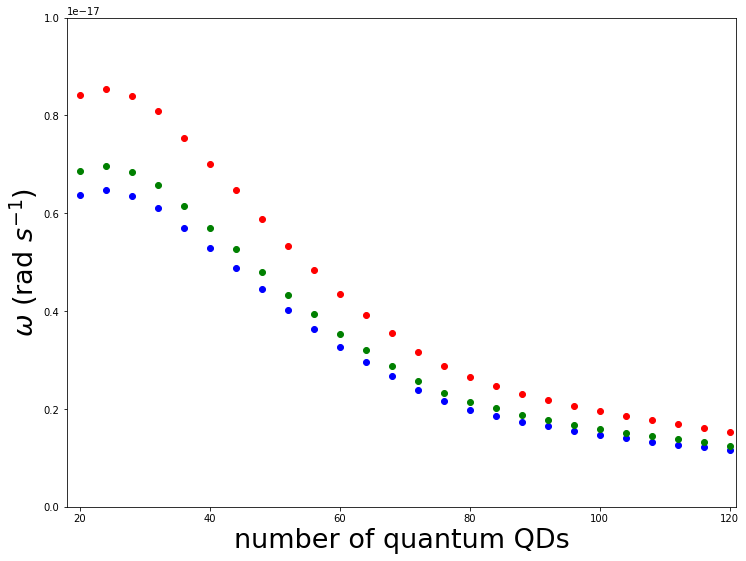

In [15]:
fig1 = plt.figure(figsize=(12, 9))
ax1 = fig1.add_subplot(111)
ax1.set_xlabel('number of quantum QDs', fontsize = '27')
#ax1.set_ylabel('Energy output (J)', fontsize = '27')
ax1.set_ylabel('$\omega$ (rad $s^{-1}$)', fontsize = '27')
ax1.set_ylim( 0 , 1e-17 )
ax1.set_xlim( 18 , N )
ax2 = fig1.add_subplot(111)
ax3 = fig1.add_subplot(111)
ax_list = [ax1, ax2, ax3]

i=0
for element in fluid_density_list:
    E_OUT_list = E_OUTbig_list[i]
    eff_percent_list = []
    j=0
    for n in np.arange(12, N, 4):
        eff = efficiency( E_in_list[j], E_OUT_list[j] )
        #print ( n, eff*100 )
        eff_percent_list.append( eff*100 )
        #ax_list[i].scatter( n_list[j], E_OUT_list[j], color= color_list[i] )
        ax_list[i].scatter( n_list[j], E_OUT_list[j], color= color_list[i] )
        j+=1
    i+=1